<a href="https://colab.research.google.com/github/rusamentiaga/pytorch-test/blob/main/2_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje automático

El aprendizaje automático en un computador permite responder ante nuevas entradas de la manera esperada. Una de las formas más habituales utilizadas hoy en día es el aprendizaje mediante ejemplos, donde se construye un modelo que permite relacionar las entradas y las salidas. De esta forma, posteriormente se puede responder ante nuevas entradas mediante la información almacenada en el modelo. Esta forma de aprendizaje se denomina supervisada cuando los ejemplos están etiquetados, es decir, donde cada entrada tiene asociada una salida esperada.

Para entender este proceso se va a realizar un ejemplo de estimación de un modelo lineal.


# Generación de los datos

En primer lugar se va a generar unos datos usando PyTorch.

In [1]:
import matplotlib.pyplot as plt
import torch
torch.version.__version__

'1.8.0+cu101'

In [2]:
torch.cuda.is_available()

True

Se generan unos datos a partir de una recta y luego se les añade ruido.

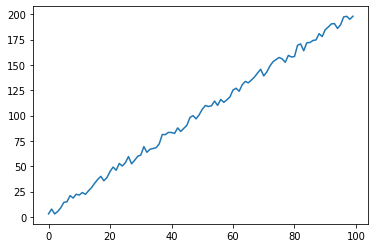

In [3]:
torch.manual_seed(0)

x = torch.tensor(range(100))
W = 2
B = 3
y = W*x + B
y = y + 10*(torch.rand(x.shape[0]) - 0.5)
plt.plot(x,y)

# Definición del modelo

Un modelo es una función matemática que relaciona entradas y salidas. Además, cada modelo tendrá unos determinados parámetros. En este caso, el modelo de una línea recta es $y = wx + b$, por tanto los parámetros son $w$ y $b$.

In [4]:
def model(x, w, b):
  return w * x + b

El modelo se puede evaluar dadas unas entradas y unos parámetros.

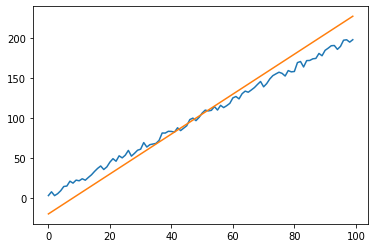

In [5]:
plt.plot(x,y)

yp = model(x, 2.5, -20)
plt.plot(x,yp)

# Función de pérdida

Para determinar la precisión de un modelo se define una función de pérdida que determine la diferencia entre la predicción y la realidad. Lo más habitual es usar la diferencia cuadrática entre la predicción y la realidad. $MSE = \frac{\sum_i^N{(yp-y)^2}}{N}$

In [6]:
def loss_fn(yp, y):
  squared_diffs = (yp - y)**2
  return squared_diffs.mean()

La función de pérdida nos permite determinar lo bien que se ajusta un modelo a los datos.

In [7]:
yp = model(x, 2.5, -20)
loss_fn(yp, y)

tensor(215.5211)

Cuanto más cerca se esté del óptimo, menor será la pérdida.

In [8]:
y3 = model(x, 2, 5)
loss_fn(y3, y)

tensor(13.0642)

# Entrenamiento con descenso del gradiente

Entrenar el modelo consiste en estimar los parámetros óptimos del modelo para unos determinados datos.

## Inicialización del modelo

El modelo se puede inicializar desde una configuración cercana a la ideal si se conoce. En la mayoría de los casos, el óptimo no es conocido lo que obliga a realizar una inicialización aleatoria con el consiguiente error.

In [9]:
wp = torch.rand(1)
bp = torch.rand(1)
yp = model(x, wp, bp)
loss_fn(yp, y)

tensor(3712.4043)

El problema consite en determinar, dada una configuración, como avanzar en la dirección adecuada.

Supongamos que se quiere buscar el mínimo de una función partiendo de un punto aleatorio. En este caso, ¿hacía donde se debería avanzar?

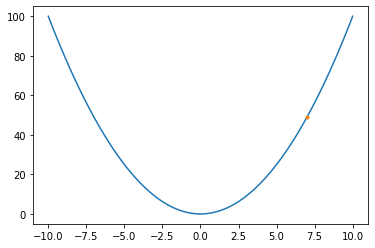

In [10]:
xt = torch.linspace(-10,10,100)
yt = xt**2
plt.plot(xt,yt)

xi = 7
yi = xi**2
plt.plot(xi,yi,'.')

Parece evidente que se debe avanzar en la dirección del gradiente. Precisamente, este el el algoritmo que se usa para buscar la configuración óptima de los parámetros del modelo: descender en la dirección del máximo gradiente.

Este mismo sistema se extiende al caso multidimensional. La idea intuitiva es la de la caída del agua sobre una superficie.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Gradient_ascent_%28surface%29.png"></center>

Matemáticamente la idea consite en calcular el ratio de cambio de la función de pérdida respecto a cada parámetro del modelo. Posteriormente, se modifica cada parámetro en la dirección que indica la función de pérdida. Analíticamente, el cálculo del gradiente se corresponde con el cálculo de la derivada.

El cálculo del gradiente de la función de pérdida respecto a cada parámetro del modelo sería:

$\frac{d(loss\_fn)}{d(w)}$

Aplicando la [regla de la cadena](https://), esta derivada se puede calcular como

$\frac{d(loss\_fn)}{d(w)} = \frac{d(loss\_fn)}{d(y)} \frac{d(y)}{d(w)}$

Para el otro parámetro:

$\frac{d(loss\_fn)}{d(b)} = \frac{d(loss\_fn)}{d(y)} \frac{d(y)}{d(b)}$


Se pueden ir planteando funciones con estas derivadas. Por ejemplo para $y = wx+b$, entonces $\frac{d(y)}{d(w)} = x$ y $\frac{d(y)}{d(b)} = 1$

*   y = wx + b
*   dy/dw = x
*   dy/db = 1
*   dloss/dw = dloss/dy * dy/dw
*   dloss/db = dloss/dy * dy/db




In [11]:
def dy_dw(x, w, b):
  return x

def dy_db(x, w, b):
  return 1.0

Por último se calcularía la derivada de la función de pérdida y se evaluaría el gradiente sobre los datos.

In [ ]:
def dloss_fn(yp, y):
  dsq_diffs = 2 * (yp - y) / yp.size(0)
  return dsq_diffs

def grad_fn(x, y, yp, w, b):
  dloss_dy = dloss_fn(yp, y)
  dloss_dw = dloss_dy * dy_dw(x, w, b)
  dloss_db = dloss_dy * dy_db(x, w, b)
  return (dloss_dw.sum(), dloss_db.sum())

Una vez que se conoce el gradiente se podría avanzar iterativamente en esa dirección a una determinada velocidad. A la velocidad a la que se avanza es a lo que se denomina el learning_rate, o ratio de aprendizaje. El algoritmosería similar al siguiente.

In [12]:
def training_loop(n_epochs, learning_rate, wp, bp, x, y):

  loss_epochs = []
  for epoch in range(n_epochs):
      # Computes our model's predicted output
      yp = model(x, wp, bp)
      
      # Compute the loss: how good the model is
      loss = loss_fn(yp, y)
      loss_epochs.append(loss)

      # Compute the gradient
      (wp_grad, bp_grad) = grad_fn(x, y, yp, wp, bp)
    
      # Updates parameters using gradients and the learning rate
      wp = wp - learning_rate * wp_grad
      bp = bp - learning_rate * bp_grad

      if epoch+1 in (1, 2, 3, 4, 5, 10, 100, 500, 1000, 5000, 10000):
        print(f'Epoch {epoch+1}, Loss {loss}, wp_grad: {wp_grad}, bp_grad: {bp_grad}')
    
  return (wp, bp, loss_epochs)

El aprendizaje se realiza a partir de un modelo inicial, con un determinado ratio de aprendizaje y durante un número de iteraciones.

In [13]:
(wp, bp, loss) = training_loop(n_epochs = 1000, 
              learning_rate = 1e-2,
              wp = 1,
              bp = 1,
              x = x,
              y = y)

Epoch 1, Loss 3491.89306640625, wp_grad: -6763.255859375, bp_grad: -102.76838684082031
Epoch 2, Loss 14572118.0, wp_grad: 437481.5, bp_grad: 6594.91015625
Epoch 3, Loss 60971732992.0, wp_grad: -28298460.0, bp_grad: -426643.625
Epoch 4, Loss 255114279387136.0, wp_grad: 1830483712.0, bp_grad: 27597362.0
Epoch 5, Loss 1.0674335821940654e+18, wp_grad: -118404694016.0, bp_grad: -1785133312.0
Epoch 10, Loss 1.3688997551443584e+36, wp_grad: 1.3408626104393427e+20, bp_grad: 2.0215571310266286e+18
Epoch 100, Loss nan, wp_grad: nan, bp_grad: nan
Epoch 500, Loss nan, wp_grad: nan, bp_grad: nan
Epoch 1000, Loss nan, wp_grad: nan, bp_grad: nan


En este caso, el sistema no converge. El ratio de aprendizaje era demasiado alto.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


TypeError: ignored

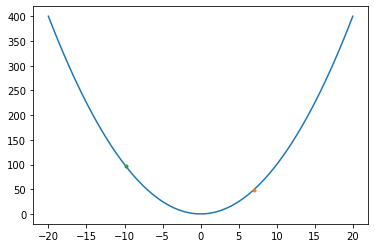

In [46]:
xt = torch.linspace(-20,20,100)
yt = xt**2
plt.plot(xt,yt)

xi = 7
yi = xi**2
plt.plot(xi,yi,'.')

ax = plt.axes()

learning_rate = 1.2

for i in range(2):

  xi = xi - learning_rate*(2*xi)
  yi = xi**2
  plt.plot(xi,yi,'.')
 
  ax.text(xi,yi, 0.01, 'sdfsdf')


In [14]:
(wp, bp, loss) = training_loop(n_epochs = 10000, 
              learning_rate = 1e-4,
              wp = 1,
              bp = 1,
              x = x,
              y = y)

Epoch 1, Loss 3491.89306640625, wp_grad: -6763.255859375, bp_grad: -102.76838684082031
Epoch 2, Loss 419.2891540527344, wp_grad: -2320.80859375, bp_grad: -35.79161071777344
Epoch 3, Loss 57.482444763183594, wp_grad: -796.37939453125, bp_grad: -12.808448791503906
Epoch 4, Loss 14.878763198852539, wp_grad: -273.2704162597656, bp_grad: -4.921734809875488
Epoch 5, Loss 9.862009048461914, wp_grad: -93.76502227783203, bp_grad: -2.215372085571289
Epoch 10, Loss 9.192130088806152, wp_grad: -0.43365478515625, bp_grad: -0.8080571889877319
Epoch 100, Loss 9.186361312866211, wp_grad: 0.01206207275390625, bp_grad: -0.7976835370063782
Epoch 500, Loss 9.16141414642334, wp_grad: 0.010945320129394531, bp_grad: -0.781667947769165
Epoch 1000, Loss 9.131614685058594, wp_grad: 0.01105499267578125, bp_grad: -0.7620790004730225
Epoch 5000, Loss 8.940637588500977, wp_grad: 0.009258270263671875, bp_grad: -0.6220826506614685
Epoch 10000, Loss 8.788850784301758, wp_grad: 0.008399009704589844, bp_grad: -0.4826639

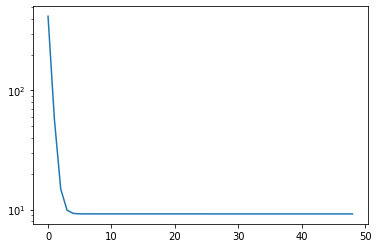

In [15]:
plt.semilogy(loss[1:50])

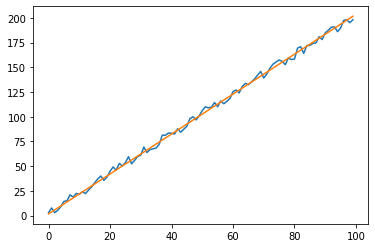

In [16]:
plt.plot(x,y)

yp = model(x, wp, bp)
plt.plot(x, yp)

In [17]:
(wp, bp, loss) = training_loop(n_epochs = 1000, 
              learning_rate = 1e-2,
              wp = 1,
              bp = 1,
              x = x*0.1,
              y = y)

Epoch 1, Loss 12238.45703125, wp_grad: -1267.3555908203125, bp_grad: -191.86839294433594
Epoch 2, Loss 1326.7628173828125, wp_grad: -416.088134765625, bp_grad: -62.56282043457031
Epoch 3, Loss 150.96116638183594, wp_grad: -136.6494140625, bp_grad: -20.11884117126465
Epoch 4, Loss 24.25811195373535, wp_grad: -44.9200439453125, bp_grad: -6.188183307647705
Epoch 5, Loss 10.60157585144043, wp_grad: -14.808431625366211, bp_grad: -1.6173384189605713
Epoch 10, Loss 8.933691024780273, wp_grad: -0.14766216278076172, bp_grad: 0.5941300392150879
Epoch 100, Loss 8.712175369262695, wp_grad: -0.05856895446777344, bp_grad: 0.38515758514404297
Epoch 500, Loss 8.56208610534668, wp_grad: -0.00793468952178955, bp_grad: 0.05267852544784546
Epoch 1000, Loss 8.559248924255371, wp_grad: -0.0006420016288757324, bp_grad: 0.004382655024528503


In [18]:
from sklearn.linear_model import LinearRegression
import numpy
linr = LinearRegression()
xnp = x.numpy().reshape((-1, 1))
ynp = y.numpy()
linr.fit(xnp, ynp)
print(linr.intercept_, linr.coef_[0])

yp = model(x, linr.coef_[0], linr.intercept_)
     
# How wrong is our model? That's the error! 
loss = loss_fn(yp, y)

print(loss)

2.5954728104808567 2.005832774851582
tensor(8.5592)


In [19]:
def training_loop_grad(n_epochs, learning_rate, wp, bp, x, y):

  wp = torch.tensor(wp, requires_grad=True, dtype=torch.float)
  bp = torch.tensor(bp, requires_grad=True, dtype=torch.float)

  for epoch in range(n_epochs):
      # Computes our model's predicted output
      yp = model(x, wp, bp)
      
      # How wrong is our model? That's the error! 
      loss = loss_fn(yp, y)
      loss.backward()

      # no_grad sirve para que pytorch no tenga en cuenta esta operación en el cáluclo del gradiente
      with torch.no_grad():
        wp -= learning_rate * wp.grad
        bp -= learning_rate * bp.grad

      if epoch+1 in (1, 2, 3, 4, 5, 10, 100, 500, 1000, 5000, 10000):
        print(f'Epoch {epoch+1}, Loss {loss}, wp_grad: {wp.grad}, bp_grad: {bp.grad}')

      wp.grad.zero_()
      bp.grad.zero_()
    
  return (wp, bp)


(wp, bp) = training_loop_grad(n_epochs = 1000, 
              learning_rate = 1e-4,
              wp = 1.0,
              bp = 1.0,
              x = x,
              y = y)

Epoch 1, Loss 3491.89306640625, wp_grad: -6763.25537109375, bp_grad: -102.76837921142578
Epoch 2, Loss 419.2891540527344, wp_grad: -2320.808349609375, bp_grad: -35.791603088378906
Epoch 3, Loss 57.482444763183594, wp_grad: -796.3792724609375, bp_grad: -12.808448791503906
Epoch 4, Loss 14.878763198852539, wp_grad: -273.2704162597656, bp_grad: -4.921734809875488
Epoch 5, Loss 9.862009048461914, wp_grad: -93.76502227783203, bp_grad: -2.215372085571289
Epoch 10, Loss 9.192130088806152, wp_grad: -0.43365478515625, bp_grad: -0.8080571889877319
Epoch 100, Loss 9.186361312866211, wp_grad: 0.012063980102539062, bp_grad: -0.7976834774017334
Epoch 500, Loss 9.16141414642334, wp_grad: 0.010945320129394531, bp_grad: -0.7816678881645203
Epoch 1000, Loss 9.131614685058594, wp_grad: 0.011056900024414062, bp_grad: -0.7620788812637329


In [20]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=1a76bcf90101bfc5c8f208a1af99203d84d2cb4097d4ff7bcb3b04aea17e84ce
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


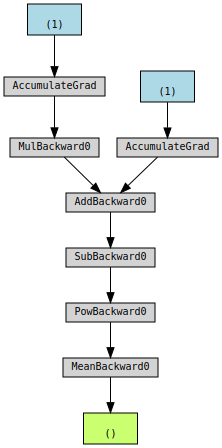

In [21]:
import torchviz

w = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)

yp = x * w + b
error = yp - y
loss = (error ** 2).mean()

torchviz.make_dot(loss)

In [22]:
def training_loop_optim(n_epochs, optimizer, wp, bp, x, y):

  for epoch in range(n_epochs):
      # Computes our model's predicted output
      yp = model(x, wp, bp)
      
      # How wrong is our model? That's the error! 
      loss = loss_fn(yp, y)
      loss.backward()

      optimizer.step()

      if epoch+1 in (1, 2, 3, 4, 5, 10, 100, 500, 1000, 5000, 10000):
        print(f'Epoch {epoch+1}, Loss {loss}, wp_grad: {wp.grad}, bp_grad: {bp.grad}')

      optimizer.zero_grad()
    
  return (wp, bp)

learning_rate = 1e-4

wp = torch.tensor(1, requires_grad=True, dtype=torch.float)
bp = torch.tensor(1, requires_grad=True, dtype=torch.float)

optimizer = torch.optim.SGD([wp, bp], lr=learning_rate)

(wp, bp) = training_loop_optim(n_epochs = 1000, 
              optimizer = optimizer,
              wp = wp,
              bp = bp,
              x = x,
              y = y)

Epoch 1, Loss 3491.89306640625, wp_grad: -6763.25537109375, bp_grad: -102.76837921142578
Epoch 2, Loss 419.2891540527344, wp_grad: -2320.808349609375, bp_grad: -35.791603088378906
Epoch 3, Loss 57.482444763183594, wp_grad: -796.3792724609375, bp_grad: -12.808448791503906
Epoch 4, Loss 14.878763198852539, wp_grad: -273.2704162597656, bp_grad: -4.921734809875488
Epoch 5, Loss 9.862009048461914, wp_grad: -93.76502227783203, bp_grad: -2.215372085571289
Epoch 10, Loss 9.192130088806152, wp_grad: -0.43365478515625, bp_grad: -0.8080571889877319
Epoch 100, Loss 9.186361312866211, wp_grad: 0.012063980102539062, bp_grad: -0.7976834774017334
Epoch 500, Loss 9.16141414642334, wp_grad: 0.010945320129394531, bp_grad: -0.7816678881645203
Epoch 1000, Loss 9.131614685058594, wp_grad: 0.011056900024414062, bp_grad: -0.7620788812637329


In [23]:
learning_rate = 1e-1

wp = torch.tensor(1, requires_grad=True, dtype=torch.float)
bp = torch.tensor(1, requires_grad=True, dtype=torch.float)

optimizer = torch.optim.Adam([wp, bp], lr=learning_rate)

(wp, bp) = training_loop_optim(n_epochs = 1000, 
              optimizer = optimizer,
              wp = wp,
              bp = bp,
              x = x,
              y = y)

Epoch 1, Loss 3491.89306640625, wp_grad: -6763.25537109375, bp_grad: -102.76837921142578
Epoch 2, Loss 2839.1259765625, wp_grad: -6096.6552734375, bp_grad: -92.66838836669922
Epoch 3, Loss 2256.255859375, wp_grad: -5432.74755859375, bp_grad: -82.60918426513672
Epoch 4, Loss 1744.1195068359375, wp_grad: -4773.8076171875, bp_grad: -72.625244140625
Epoch 5, Loss 1302.919921875, wp_grad: -4122.5400390625, bp_grad: -62.757545471191406
Epoch 10, Loss 102.81088256835938, wp_grad: -1111.7730712890625, bp_grad: -17.139726638793945
Epoch 100, Loss 8.628947257995605, wp_grad: -8.459798812866211, bp_grad: -0.3829543888568878
Epoch 500, Loss 8.561346054077148, wp_grad: 0.04411125183105469, bp_grad: -0.04572838544845581
Epoch 1000, Loss 8.55922794342041, wp_grad: 0.0007381439208984375, bp_grad: -0.0008340030908584595


Text(0.5, 1.0, 'Model: y = x*2.0058577060699463 + 2.593824625015259')

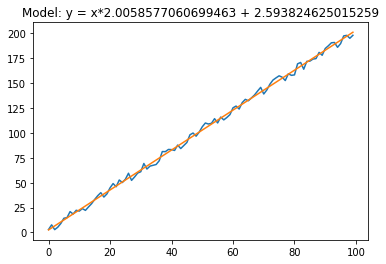

In [24]:
plt.plot(x,y)

yp = model(x, wp, bp)
plt.plot(x, yp.detach().numpy())
plt.title(f'Model: y = x*{wp} + {bp}')

In [25]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.w = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        return self.w * x + self.b

linearModel = LinearModel()

device = torch.device("cpu")
linearModel.to(device)

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(linearModel.parameters(), lr=1e-1)

for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = linearModel(x)

    loss = criterion(y_pred, y)

    if epoch+1 in (1, 2, 3, 4, 5, 10, 100, 500, 1000, 5000, 10000):
      print(f'Epoch {epoch+1}, Loss {loss}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Model: y = {linearModel.b} + {linearModel.w} x')

Epoch 1, Loss 332.0518493652344
Epoch 2, Loss 157.12794494628906
Epoch 3, Loss 51.96406555175781
Epoch 4, Loss 11.540021896362305
Epoch 5, Loss 20.641157150268555
Epoch 10, Loss 62.1997184753418
Epoch 100, Loss 9.000170707702637
Epoch 500, Loss 8.559228897094727
Epoch 1000, Loss 8.559226989746094
Epoch 5000, Loss 8.559226036071777
Epoch 10000, Loss 8.559231758117676
Model: y = 2.595482110977173 + 2.0058412551879883 x


In [26]:
linearModel = torch.nn.Linear(1, 1)

# Loss and optimizer
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(linearModel.parameters(), lr=1e-1)

xval = torch.unsqueeze(x,1).float()
yval = torch.unsqueeze(y,1).float()

# Train the model
for epoch in range(10000):

    # Forward pass
    yp = linearModel(xval)
    loss = criterion(yp, yval)

    if epoch+1 in (1, 2, 3, 4, 5, 10, 100, 500, 1000, 5000, 10000):
      print(f'Epoch {epoch+1}, Loss {loss}')
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Model: y = {linearModel.bias.item()} + {linearModel.weight.item()} x')

Epoch 1, Loss 19647.1796875
Epoch 2, Loss 18050.712890625
Epoch 3, Loss 16523.900390625
Epoch 4, Loss 15067.86328125
Epoch 5, Loss 13683.53515625
Epoch 10, Loss 7855.986328125
Epoch 100, Loss 8.70557689666748
Epoch 500, Loss 8.573247909545898
Epoch 1000, Loss 8.560593605041504
Epoch 5000, Loss 8.559226989746094
Epoch 10000, Loss 8.559225082397461
Model: y = 2.5954713821411133 + 2.005831718444824 x
